## RandomForest на данных GPS

__Папка с данными на gdrive__

https://drive.google.com/drive/folders/1FeUwrVfxp09xAifiMngwtfrRZ8nhtj8T?usp=sharing



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import shap
from matplotlib import pyplot as plt
from matplotlib import colors
from os import listdir
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from snippets import *

%matplotlib inline

In [2]:
DATA_PATH = "../../data"

GPS_PATH = f"{DATA_PATH}/gps_data_fixed.csv"
ACCEL_PATH = f"{DATA_PATH}/accel_data_fixed.csv"

listdir(DATA_PATH)

['data_good_right_dates',
 'drivers_stats.csv',
 'subm_accel_gps_proba.csv',
 'gps_data.csv',
 'unlabeled',
 'gps_data_raw.csv',
 'matched_routs.csv',
 'matched_routs_fixed.csv',
 'matched_data_fixed.csv',
 'good_data',
 'matched_data.csv',
 'points_stats.csv',
 'proba_rf.csv',
 'subm_accel_tm.csv',
 'gps_data_fixed.csv',
 'submission_rf.csv',
 'subm_accel_tm_proba.csv',
 'accel_data.csv',
 'accel_data_raw.csv',
 'drivers_with_gps_and_sl_problems',
 'accel_data_outlier.csv',
 'records',
 'track_20211214_211500.csv',
 'gps_stats.csv',
 'submission_catboost.csv',
 'subm_accel_gps.csv',
 'rides_of_drivers.csv',
 'accel_stats.csv',
 'gps_data_outlier.csv',
 'accel_data_fixed.csv',
 'proba_catboost.csv']

## GPS Raw Dataset

In [3]:
df_gps_raw = pd.read_csv(f"{DATA_PATH}/gps_data_raw.csv", parse_dates=[0, 3]) \
    .sort_values(by=["driver_hash", "gps_time"]) \
    .reset_index(drop=True)

## Preprocessing

In [4]:
calc_distance = np.vectorize(haversine_approx)

def make_preprocessing_fixed(df, time_col, prefix, time_diff=1):
    col_delta = f"{prefix}_delta"
    col_distance = f"{prefix}_distance"
    col_speed = f"{prefix}_speed"
    col_accel = f"{prefix}_accel"
    col_outlier = f"{prefix}_outlier"
    col_staying = f"{prefix}_staying"
    
    df = df.sort_values(by=["driver_hash", time_col]) \
        .copy()
        
    # Точность GPS 1 секунда, есть точки у которых разница во времени равна 0
    # для таких точек разницу во времени задаю как 1 / их количество
    df[col_delta] = df[time_col].diff(time_diff).dt.total_seconds().abs()
    df[col_delta].values[0] = df[col_delta].max()
    
    df_fix = df.groupby(by=["driver_hash", time_col], sort=False) \
        .count()["fraud"] \
        .rename("count") \
        .reset_index()

    df_fix = df[["driver_hash", time_col, col_delta]] \
        .merge(df_fix, on=["driver_hash", time_col])

    mask = df_fix[col_delta] == 0.0
    df_fix.loc[mask, col_delta] = (1.0 / df_fix.loc[mask, "count"])
    
    df[col_delta] = df_fix[col_delta]
    
    # расстояние
    df[col_distance] = calc_distance(df['lat'], df['lon'], df['lat'].shift(time_diff), df['lon'].shift(time_diff))
    df[col_distance].values[0] = df[col_distance].values[1]

    # скрость
    df[col_speed] = df[col_distance] / df[col_delta]

    # ускорение
    df[col_accel] = df[col_speed].diff(time_diff) / df[col_delta]
    df[col_accel].values[0] = df[col_speed].values[0] / df[col_delta].values[0]

    # округляю
    df[col_distance] = df[col_distance].round(1) #.replace([np.inf, np.nan], 0.0).clip(None, 3600)
    df[col_speed] = df[col_speed].round(1)       #.replace([np.inf, np.nan], 0.0).clip(None, 3600)
    df[col_accel] = df[col_accel].round(2)       #.replace([np.inf, np.nan], 0.0).clip(None, 3600)

    # аномальные точки
    df[col_outlier] = 0.0
    mask = (df[col_speed] > 50.0) | (df[col_accel].abs() > 30.0)
    df.loc[mask, col_outlier] = 1.0

    # точки остановок
    df[col_staying] = 0.0
    mask = (df[col_distance] < 1.0) | (df[col_speed] < 1.0)
    df.loc[mask, col_staying] = 1.0

    return df

In [5]:
df_gps = make_preprocessing_fixed(df_gps_raw, "gps_time", "gps")
df_gps = make_preprocessing_fixed(df_gps, "time", "tm")

describe(df_gps)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2020-07-31 17:37:31.378774272,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2020-07-31 17:37:28.866647296,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076
gps_delta,float64,5.05029e+06,1315.76,0.025641,2,3,3,1.91032e+08,335148
gps_distance,float64,5.05029e+06,28.0507,0,0.1,5.2,24.8,6.45109e+06,6079.83
gps_speed,float64,5.05029e+06,6.89002,0,0,2,9.7,1.29022e+06,876.172
gps_accel,float64,5.05029e+06,0.811226,-580743,-0.12,0,0.12,619814,872.826


(5050292, 18)

## Enulated tracks

In [6]:
df_emul = pd.read_csv(f"{DATA_PATH}/track_20211214_211500.csv", parse_dates=[0, 3]) \
    .sort_values(by=["gps_time"]) \
    .reset_index(drop=True)
df_emul["driver_hash"] = 10000000001
df_emul["fraud"] = -2

df_emul = make_preprocessing_fixed(df_emul, "gps_time", "gps")
df_emul = make_preprocessing_fixed(df_emul, "time", "tm")

describe(df_emul)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],19788,2021-12-14 15:09:01.193046272,2021-12-12 18:25:29,2021-12-14 19:26:27.750000128,2021-12-14 20:48:54.500000,2021-12-14 22:11:21.250000128,2021-12-14 23:33:48,NaN
lat,float64,19788,55.7624,55.567,55.6975,55.739,55.8223,55.9875,0.102566
lon,float64,19788,37.5646,37.1562,37.4248,37.5687,37.6929,37.9032,0.180755
gps_time,datetime64[ns],19788,2021-12-14 15:09:01.193046272,2021-12-12 18:25:29,2021-12-14 19:26:27.750000128,2021-12-14 20:48:54.500000,2021-12-14 22:11:21.250000128,2021-12-14 23:33:48,NaN
driver_hash,int64,19788,1e+10,1e+10,1e+10,1e+10,1e+10,1e+10,0
fraud,int64,19788,-2,-2,-2,-2,-2,-2,0
gps_delta,float64,19788,13.573,1,1,1,1,77284,924.131
gps_distance,float64,19788,20.3362,0,11.9,15.7,19.9,38882.7,360.567
gps_speed,float64,19788,15.1285,0,11.6,15.3,19.1,7763.6,55.4314
gps_accel,float64,19788,0.049528,-7752.4,-2.25,0,2.24,7761.59,78.1075


(19788, 18)

In [7]:
display(df_gps.shape)
display(df_emul.shape)

df_gps = pd.concat((df_gps, df_emul), axis=0)
df_gps.shape

(5050292, 18)

(19788, 18)

(5070080, 18)

## Разбивка на поездки

In [8]:
ROUTE_SPLIT_COLUMN = "gps_delta"
ROUTE_SPLIT_INTERVAL = 30

# разбиваю на поездки, если между точками разница больше ROUTE_SPLIT_INTERVAL секунд
df_gps["route_diff"] = pd.to_timedelta(df_gps[ROUTE_SPLIT_COLUMN], unit="seconds") \
    .dt.total_seconds()

df_gps["route_start"] = 0
df_gps.loc[df_gps["route_diff"] > ROUTE_SPLIT_INTERVAL, "route_start"] = 1

df_gps["route_id"] = df_gps["route_start"].cumsum().astype(int)

df_gps[["gps_time", "gps_delta", "route_start", "route_diff", "route_id"]]

,gps_time,gps_delta,route_start,route_diff,route_id
0,2020-11-10 03:08:12,191031533.0,1,191031533.0,1
1,2020-11-10 03:42:48,2076.0,1,2076.0,2
2,2020-11-10 06:38:30,10542.0,1,10542.0,3
3,2020-11-10 06:38:31,1.0,0,1.0,3
4,2020-11-10 06:54:36,965.0,1,965.0,4
...,...,...,...,...,...
19783,2021-12-14 23:33:44,1.0,0,1.0,21487
19784,2021-12-14 23:33:45,1.0,0,1.0,21487
19785,2021-12-14 23:33:46,1.0,0,1.0,21487
19786,2021-12-14 23:33:47,1.0,0,1.0,21487


In [40]:
# [None, -1, 0, 1]
FORCE_FRAUD = 1

# Выбор случайного водителя
df_driver, driver_hash, driver_fraud = sample_driver(df_gps, FORCE_FRAUD)
# driver_routs = df_driver["route_id"].astype(int)

center = (df_driver["lat"].mean(), df_driver["lon"].mean())
m = folium.Map(location=center, zoom_start=10, legend=True)

map_driver_points(m, df_driver, driver_hash, label=driver_fraud, color="black", weight=10)

color = df_driver.head(1)["fraud"].replace({1:"red", 0:"green", -1:"blue", -2:"yellow"}).values[0]

for rx in df_driver["route_id"].unique():
    gps_route = df_driver.loc[df_driver["route_id"] == rx,["lat", "lon"]]
    if gps_route.shape[0] > 1:
        fg = folium.FeatureGroup(name=f"route{rx}_({len(gps_route)})")
        folium.PolyLine(gps_route, color=color, weight=6, opacity=0.8).add_to(fg)
        fg.add_to(m)
    
folium.map.LayerControl('topleft', collapsed=False).add_to(m)

m

## Классификация точек

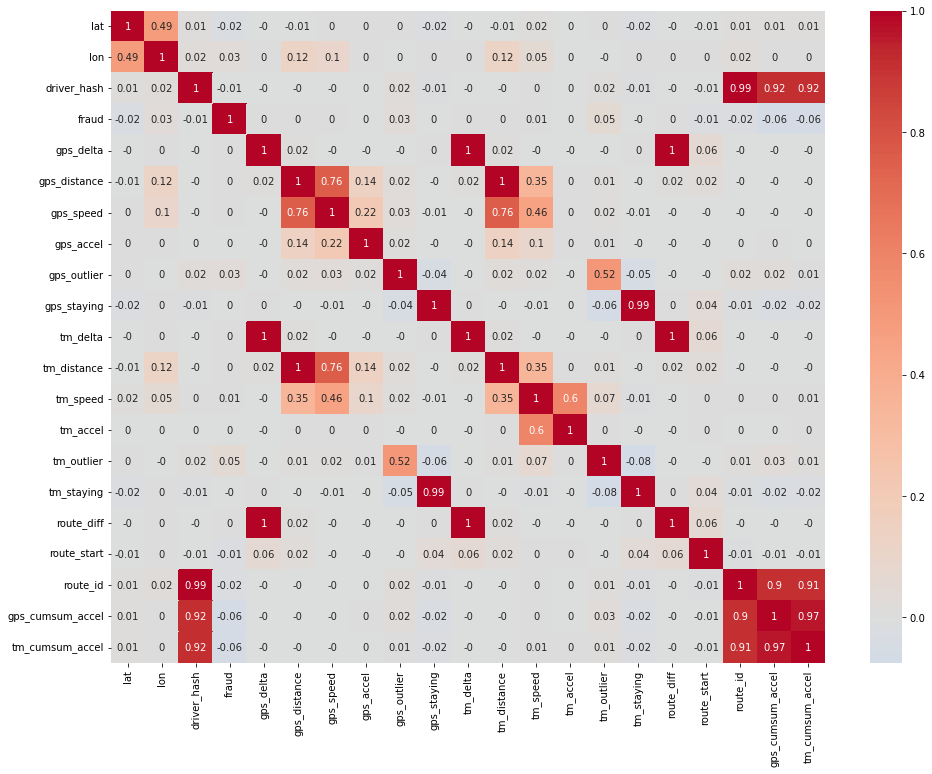

In [10]:
df_gps["gps_cumsum_accel"] = df_gps["gps_accel"].cumsum()
df_gps["tm_cumsum_accel"] = df_gps["tm_accel"].cumsum()

corr = df_gps.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", annot=corr.round(2), center=0)
plt.show()

## Классификатор1

In [11]:
columns = [
    "gps_delta",
    "gps_distance",
    "gps_speed",
    "gps_accel",
    "gps_cumsum_accel"
]

X = df_gps.loc[df_gps["fraud"] >= 0, columns].copy()
y = df_gps.loc[df_gps["fraud"] >= 0, "fraud"].copy()

display(f"Features/Target: {(X.shape, y.shape)}")

X_train, X_test, y_train, y_test = train_test_split(X, y)
display(f"Train/Test: {(X_train.shape, y_train.shape, X_test.shape, y_test.shape)}")

clf_gps = RandomForestClassifier(n_jobs=-1)
clf_gps.fit(X_train, y_train)
proba = clf_gps.predict_proba(X_test)

imps = pd.Series(clf_gps.feature_importances_, X_train.columns).sort_values(ascending=False)
display(imps.rename("Importances").to_frame().T)

'Features/Target: ((1066109, 5), (1066109,))'

'Train/Test: ((799581, 5), (799581,), (266528, 5), (266528,))'

,gps_cumsum_accel,gps_delta,gps_distance,gps_speed,gps_accel
Importances,0.889629,0.0379,0.02559,0.024078,0.022803


Train    80678.0
Test     26857.0
Pred     26765.0
dtype: float64

accuracy_score    0.998552
f1_score          0.992801
dtype: float64

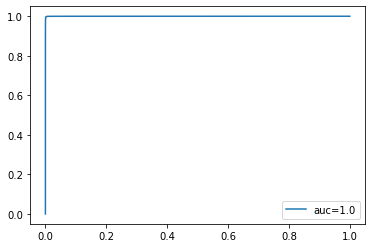

In [12]:
y_pred = pd.Series(proba.argmax(axis=1), index=X_test.index, name="Pred")
display(pd.concat((y_train.rename("Train"), y_test.rename("Test"), y_pred), axis=1).sum())

display(pd.Series((accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)),
                  index = ("accuracy_score", "f1_score")))

auc = roc_auc_score(y_test, proba[::,1])
fpr, tpr, _ = roc_curve(y_test,  proba[::,1])
plt.plot(fpr,tpr,label=f"auc={auc:.2}")
plt.legend(loc=4)
plt.show()

## Классификатор2

In [13]:
columns = [
    "tm_delta",
    "tm_distance",
    "tm_speed",
    "tm_accel",
    "tm_cumsum_accel"
]

X = df_gps.loc[df_gps["fraud"] >= 0, columns].copy()
y = df_gps.loc[df_gps["fraud"] >= 0, "fraud"].copy()

display(f"Features/Target: {(X.shape, y.shape)}")

X_train, X_test, y_train, y_test = train_test_split(X, y)
display(f"Train/Test: {(X_train.shape, y_train.shape, X_test.shape, y_test.shape)}")

clf_tm = RandomForestClassifier(n_jobs=-1)
clf_tm.fit(X_train, y_train)
proba = clf_tm.predict_proba(X_test)

imps = pd.Series(clf_tm.feature_importances_, X_train.columns).sort_values(ascending=False)
display(imps.rename("Importances").to_frame().T)

'Features/Target: ((1066109, 5), (1066109,))'

'Train/Test: ((799581, 5), (799581,), (266528, 5), (266528,))'

,tm_cumsum_accel,tm_delta,tm_distance,tm_accel,tm_speed
Importances,0.907847,0.035388,0.020014,0.019074,0.017676


Train    80727.0
Test     26808.0
Pred     26786.0
dtype: float64

accuracy_score    0.999775
f1_score          0.998880
dtype: float64

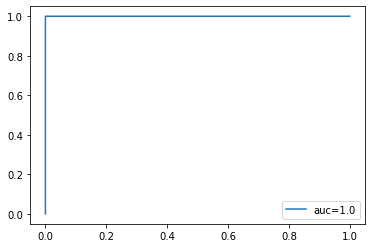

In [14]:
y_pred = pd.Series(proba.argmax(axis=1), index=X_test.index, name="Pred")
display(pd.concat((y_train.rename("Train"), y_test.rename("Test"), y_pred), axis=1).sum())

display(pd.Series((accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)),
                  index = ("accuracy_score", "f1_score")))

auc = roc_auc_score(y_test, proba[::,1])
fpr, tpr, _ = roc_curve(y_test,  proba[::,1])
plt.plot(fpr,tpr,label=f"auc={auc:.2}")
plt.legend(loc=4)
plt.show()

## Predictions

In [15]:
columns = [
    "gps_delta",
    "gps_distance",
    "gps_speed",
    "gps_accel",
    "gps_cumsum_accel"
]

df_gps["gps_pred"] = clf_gps.predict(df_gps[columns])
df_gps["gps_pred"].value_counts()

0    3484684
1    1585396
Name: gps_pred, dtype: int64

In [16]:
columns = [
    "tm_delta",
    "tm_distance",
    "tm_speed",
    "tm_accel",
    "tm_cumsum_accel"
]

df_gps["tm_pred"] = clf_tm.predict(df_gps[columns])
df_gps["tm_pred"].value_counts()

0    3286730
1    1783350
Name: tm_pred, dtype: int64

In [17]:
df_gps[["gps_pred", "tm_pred"]].value_counts().sort_index()

gps_pred  tm_pred
0         0          3110663
          1           374021
1         0           176067
          1          1409329
dtype: int64

In [18]:
df_pred = df_gps \
    .groupby(by=["fraud", "driver_hash"]) \
    .agg({"gps_pred": "sum", "tm_pred": "sum", "fraud": "count"}) \
    .rename(columns={"fraud": "points"}) \
    .sort_index()

df_pred.tail(50)

gps_pred  tm_pred  points
fraud driver_hash                                    
-1     8441926883992743797         0       40   38528
       8472641716551984138         0       33    8475
       8484618983568667576         0       23   24589
       8495411695898023080         1       25   22783
       8708539809027958552         4       48   31907
       8799657288824140068         0       43   20439
       8894636921649230831         0        1   13871
       8921990331059051231         0        0   23350
       8979134000488028450         0        1   24378
       8979322487342770688         0        0    1060
       9028001926696043346        17        0   17144
       9142516420276355425         0        0    7481
       9206466041403273735         0        0   19370
 0    -8855449059095575743        16        1   44773
      -8285444573847573076         0        0   25396
      -4472006672024242679       110        2   36834
      -4294745953159109974         0        3   40827
      -4080393840523659459         0        4   41959
      -3754613297758316782         6        4   46659
      -2326108064915089301        15        4   22128
      -917569374742463282          0        0   85301
       50909632375203636           0        0   53188
       102237250308562244          0        0   55713
       254619638422759589          0        0   50866
       269342988796658819          0        0   44981
       631642712709916337          0        0   31776
       2339565149906962126         0        0   34398
       4633179079544742811         0        0   57838
       4792989220905314639         0        0   25243
       4805235792201203747         0        0   24202
       4957397998143787649         0        0   30327
       5900186570978300677         0        0   34018
       5960642249321857991         0        0   42616
       7363918686470073741         0        0   50682
       7934040023444826650         0        0   46228
       8893554023910460211         0        1   32621
 1    -8915411586673655243        51       55      55
      -8729475955540025841      3049     3086    3087
      -7745607963253656189     15994    15994   15994
      -7078426713190014901      1799     1799    1799
      -6715898809375179473     14887    14887   14887
      -4687681644253937266      1995     1995    1995
      -4385647888228392778      6008     6120    6131
      -3962756297262839169     11096    11124   11129
      -2988946964244641879      7752     7742    7755
      -2132251359044308970      7711     7742    7749
       1293535473153840726        17       17      17
       2025312357143911724     16948    16946   16948
       2765355583032989810     19965    19965   19965
       8569741546477592565        20       22      24

## Emulator predictions

In [19]:
df_pred.head(1)

,,gps_pred,tm_pred,points
fraud,driver_hash,,,
-2,10000000001,0,0,19788


## Driver fraud rank

In [20]:
df_pred["gps_proba"] = df_pred["gps_pred"] / df_pred["points"]
df_pred["tm_proba"] = df_pred["tm_pred"] / df_pred["points"]
df_pred["fraud_gps"] = df_pred["gps_proba"].round(0).astype(int)
df_pred["fraud_tm"] = df_pred["tm_proba"].round(0).astype(int)
df_pred = df_pred.reset_index()
df_pred

,fraud,driver_hash,gps_pred,tm_pred,points,gps_proba,tm_proba,fraud_gps,fraud_tm
0,-2,10000000001,0,0,19788,0.000000,0.000000,0,0
1,-1,-9218579406240981296,12861,16985,17592,0.731071,0.965496,1,1
2,-1,-9148378939849570226,1802,2246,2430,0.741564,0.924280,1,1
3,-1,-9090289600630456229,2882,3895,4458,0.646478,0.873710,1,1
4,-1,-9073383204587901813,9443,11984,12885,0.732868,0.930074,1,1
...,...,...,...,...,...,...,...,...,...
313,1,-2132251359044308970,7711,7742,7749,0.995096,0.999097,1,1
314,1,1293535473153840726,17,17,17,1.000000,1.000000,1,1
315,1,2025312357143911724,16948,16946,16948,1.000000,0.999882,1,1
316,1,2765355583032989810,19965,19965,19965,1.000000,1.000000,1,1


## Earlier submisstion

In [46]:
df_rf = pd.read_csv(f"{DATA_PATH}/submission_rf.csv")
df_rf.columns = ["driver_hash", "fraud_rf"]

df_cb = pd.read_csv(f"{DATA_PATH}/submission_catboost.csv")
df_cb.columns = ["driver_hash", "fraud_cb"]

df_submission = df_rf.merge(df_cb, on="driver_hash")
df_submission = df_pred.merge(df_submission, on="driver_hash")

df_submission[["fraud_gps", "fraud_tm", "fraud_rf", "fraud_cb"]].value_counts().sort_index()

fraud_gps  fraud_tm  fraud_rf  fraud_cb
0          0         0         0           51
                               1            7
                     1         0            1
                               1           82
           1         0         0            6
                               1            3
                     1         0            1
                               1           16
1          0         0         0           14
                               1            1
                     1         1           20
           1         0         0           24
                               1            5
                     1         1           49
dtype: int64

## Clustering

In [47]:
columns = [
    "gps_delta",
    "gps_distance",
    "gps_speed",
    "gps_accel",
    "gps_cumsum_accel"
]

df_clust = df_gps[["fraud", "driver_hash"]].copy()

for i in range(2, 15):
    np.random.seed(100)
    
    clust = KMeans(n_clusters=i)
    clust.fit(df_gps[columns])
    
    labels = pd.Series(clust.labels_, df_gps.index, name=f"clusters{i}")
    
    l = labels.value_counts().rename("Points")
    l0 = labels[df_gps["fraud"] == 0].value_counts().rename("Good")
    l1 = labels[df_gps["fraud"] == 1].value_counts().rename("Fraud")
    display(pd.concat((l, l0, l1), axis=1).T)
    
    df_clust = pd.concat((df_clust, labels.to_frame()), axis=1)


,0,1
Points,5050266.0,26.0
Good,958561.0,13.0
Fraud,107535.0,NaN


,0,1,2
Points,3684578.0,26.0,1365688.0
Good,614790.0,13.0,343771.0
Fraud,107511.0,NaN,24.0


,0,1,2,3
Points,3684504.0,20.0,1365659.0,109.0
Good,614786.0,10.0,343766.0,12.0
Fraud,107509.0,NaN,23.0,3.0


,0,1,2,3,4
Points,1365649.0,3684461.0,16.0,152.0,14.0
Good,343766.0,614786.0,8.0,7.0,7.0
Fraud,23.0,107507.0,NaN,5.0,NaN


,0,1,2,3,4,5
Points,2269606.0,1365649.0,16.0,14.0,1414855.0,152.0
Good,343869.0,343766.0,8.0,7.0,270917.0,7.0
Fraud,70576.0,23.0,NaN,NaN,36931.0,5.0


,0,1,2,3,4,5,6
Points,2269596.0,10.0,1365649.0,10.0,163.0,1414852.0,12.0
Good,343869.0,5.0,343766.0,5.0,6.0,270917.0,6.0
Fraud,70576.0,NaN,23.0,NaN,5.0,36931.0,NaN


,0,1,2,3,4,5,6,7
Points,1414842.0,10.0,1365643.0,63.0,10.0,2269576.0,10.0,138.0
Good,270917.0,5.0,343766.0,7.0,5.0,343869.0,5.0,NaN
Fraud,36930.0,NaN,23.0,2.0,NaN,70574.0,NaN,6.0


,0,1,2,3,4,5,6,7,8
Points,1414842.0,10.0,994352.0,63.0,2269576.0,10.0,10.0,371291.0,138.0
Good,270917.0,5.0,188299.0,7.0,343869.0,5.0,5.0,155467.0,NaN
Fraud,36930.0,NaN,23.0,2.0,70574.0,NaN,NaN,NaN,6.0


,0,1,2,3,4,5,6,7,8,9
Points,1414841.0,10.0,994350.0,9.0,63.0,2269573.0,10.0,135.0,10.0,371291.0
Good,270917.0,5.0,188299.0,5.0,1.0,343869.0,5.0,NaN,6.0,155467.0
Fraud,36930.0,NaN,23.0,NaN,3.0,70574.0,NaN,5.0,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10
Points,1414842.0,9.0,994351.0,9.0,2269576.0,60.0,7.0,10.0,133.0,4.0,371291.0
Good,270917.0,5.0,188299.0,5.0,343869.0,1.0,3.0,6.0,NaN,2.0,155467.0
Fraud,36930.0,NaN,23.0,NaN,70574.0,3.0,NaN,NaN,5.0,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10,11
Points,371434.0,1046240.0,4.0,9.0,63.0,1955227.0,9.0,994207.0,135.0,7.0,10.0,682947.0
Good,155610.0,321820.0,2.0,5.0,1.0,258569.0,5.0,188156.0,NaN,3.0,6.0,34397.0
Fraud,NaN,5398.0,NaN,NaN,3.0,70574.0,NaN,23.0,5.0,NaN,NaN,31532.0


,0,1,2,3,4,5,6,7,8,9,10,11,12
Points,1955213.0,7.0,994340.0,81.0,681846.0,9.0,9.0,371291.0,55.0,91.0,9.0,4.0,1047337.0
Good,258569.0,3.0,188299.0,NaN,34397.0,5.0,5.0,155467.0,2.0,1.0,5.0,2.0,321819.0
Fraud,70572.0,NaN,23.0,3.0,30432.0,NaN,NaN,NaN,2.0,5.0,NaN,NaN,6498.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Points,835977.0,7.0,994340.0,9.0,1187950.0,55.0,82.0,9.0,1081609.0,371291.0,9.0,4.0,578860.0,90.0
Good,270916.0,3.0,188299.0,5.0,116825.0,2.0,NaN,5.0,227044.0,155467.0,5.0,2.0,NaN,1.0
Fraud,16963.0,NaN,23.0,NaN,47619.0,2.0,3.0,NaN,22953.0,NaN,NaN,NaN,19967.0,5.0


In [48]:
df_clust.groupby(["fraud", "driver_hash"], sort=True).agg(set).tail(50)

clusters2 clusters3 clusters4 clusters5 clusters6  \
fraud driver_hash                                                              
-1     8441926883992743797       {0}       {2}       {2}       {0}       {1}   
       8472641716551984138       {0}       {2}       {2}       {0}       {1}   
       8484618983568667576       {0}       {2}       {2}       {0}       {1}   
       8495411695898023080       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       8708539809027958552       {0}       {2}       {2}       {0}       {1}   
       8799657288824140068       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       8894636921649230831    {0, 1}    {1, 2}    {2, 3}    {0, 4}    {1, 3}   
       8921990331059051231       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       8979134000488028450       {0}       {2}       {2}       {0}       {1}   
       8979322487342770688       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       9028001926696043346       {0}       {2}       {2}       {0}       {1}   
       9142516420276355425       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       9206466041403273735       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
 0    -8855449059095575743    {0, 1}    {0, 1}    {0, 1}    {1, 2}    {0, 2}   
      -8285444573847573076       {0}       {0}    {0, 3}    {1, 4}    {0, 3}   
      -4472006672024242679    {0, 1}    {0, 1}    {0, 3}    {1, 4}    {0, 3}   
      -4294745953159109974    {0, 1}    {0, 1}    {0, 1}    {1, 2}    {0, 2}   
      -4080393840523659459    {0, 1}    {0, 1}    {0, 1}    {1, 2}    {0, 2}   
      -3754613297758316782       {0}       {0}    {0, 3}    {1, 3}    {0, 5}   
      -2326108064915089301       {0}       {0}    {0, 3}    {1, 3}    {0, 5}   
      -917569374742463282     {0, 1}    {0, 1}    {0, 1}    {1, 2}    {0, 2}   
       50909632375203636      {0, 1}    {0, 1}    {0, 1}    {1, 4}    {3, 4}   
       102237250308562244        {0}       {0}    {0, 3}    {1, 4}    {3, 4}   
       254619638422759589     {0, 1}    {0, 1}    {0, 1}    {1, 2}    {2, 4}   
       269342988796658819        {0}       {0}       {0}       {1}       {4}   
       631642712709916337     {0, 1}    {0, 1}    {0, 1}    {1, 2}    {2, 4}   
       2339565149906962126    {0, 1}    {0, 1}    {0, 3}    {1, 4}    {3, 4}   
       4633179079544742811    {0, 1}    {1, 2}    {1, 2}    {0, 2}    {1, 2}   
       4792989220905314639       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       4805235792201203747       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       4957397998143787649       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       5900186570978300677       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       5960642249321857991       {0}       {2}    {2, 3}    {0, 3}    {1, 5}   
       7363918686470073741    {0, 1}    {1, 2}    {1, 2}    {0, 2}    {1, 2}   
       7934040023444826650    {0, 1}    {1, 2}    {1, 2}    {0, 4}    {1, 3}   
       8893554023910460211    {0, 1}    {1, 2}    {2, 3}    {0, 4}    {1, 3}   
 1    -8915411586673655243       {0}       {0}       {0}       {1}       {0}   
      -8729475955540025841       {0}       {0}       {0}    {1, 3}    {0, 5}   
      -7745607963253656189       {0}       {0}       {0}       {1}       {0}   
      -7078426713190014901       {0}       {0}    {0, 3}    {1, 3}    {0, 5}   
      -6715898809375179473       {0}       {0}       {0}       {1}       {0}   
      -4687681644253937266       {0}       {0}       {0}       {1}       {0}   
      -4385647888228392778       {0}       {0}       {0}       {1}       {0}   
      -3962756297262839169       {0}       {0}       {0}       {1}    {0, 4}   
      -2988946964244641879       {0}       {0}       {0}       {1}       {0}   
      -2132251359044308970       {0}       {0}    {0, 3}    {1, 3}    {0, 5}   
       1293535473153840726       {0}       {0}       {0}    {1, 3}    {4, 5}   
       2025312357143911724       {0}       {0}       {0}       {1}       {4}   
       2765355583032989810 

## Visialization

In [49]:
# [None, -1, 0, 1]
FORCE_FRAUD = None

# Выбор случайного водителя
driver_gps, driver_hash, driver_fraud = sample_driver(df_gps, FORCE_FRAUD)
driver_gps = driver_gps.sort_values(by="gps_time").reset_index(drop=True)

gps_pred = driver_gps[driver_gps["gps_pred"] == 1]
tm_pred = driver_gps[driver_gps["tm_pred"] == 1]

center = (driver_gps["lat"].mean(), driver_gps["lon"].mean())
m = folium.Map(location=center, zoom_start=10, legend=True)

# Маршрут по данным  GPS
map_driver_points(m, driver_gps, driver_hash, label="gps")

fg = folium.FeatureGroup(f"gps_pred {gps_pred.shape[0]}/{driver_gps.shape[0]}").add_to(m)
for i, r in tqdm(gps_pred.iterrows()):
    folium.Marker((r["lat"], r["lon"]), popup=str(r), icon=folium.Icon(color="red")).add_to(fg)

fg = folium.FeatureGroup(f"tm_pred {tm_pred.shape[0]}/{driver_gps.shape[0]}").add_to(m)
for i, r in tqdm(tm_pred.iterrows()):
    folium.Marker((r["lat"], r["lon"]), popup=str(r), icon=folium.Icon(color="purple")).add_to(fg)

folium.map.LayerControl('topleft', collapsed= False).add_to(m)
m

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [56]:
df_subm = df_pred[df_pred["fraud"] == -1]
df_subm

,fraud,driver_hash,gps_pred,tm_pred,points,gps_proba,tm_proba,fraud_gps,fraud_tm,prod_proba
0,-1,-9218579406240981296,14898,15888,17592,0.846862,0.903138,1,1,0.764833
1,-1,-9148378939849570226,1799,1938,2430,0.740329,0.797531,1,1,0.590435
2,-1,-9090289600630456229,3144,3486,4458,0.705249,0.781965,1,1,0.551480
3,-1,-9073383204587901813,10755,11296,12885,0.834692,0.876678,1,1,0.731756
4,-1,-9067392653059450527,11346,12266,14939,0.759489,0.821072,1,1,0.623595
...,...,...,...,...,...,...,...,...,...,...
275,-1,8979134000488028450,0,3,24378,0.000000,0.000123,0,0,0.000000
276,-1,8979322487342770688,0,3,1060,0.000000,0.002830,0,0,0.000000
277,-1,9028001926696043346,0,0,17144,0.000000,0.000000,0,0,0.000000
278,-1,9142516420276355425,0,2,7481,0.000000,0.000267,0,0,0.000000


In [59]:
df_subm[["driver_hash", "fraud_gps"]].to_csv(f"{DATA_PATH}/subm_accel_gps.csv", index=False)
!cat "{DATA_PATH}/subm_accel_gps.csv"


driver_hash,fraud_gps
-9218579406240981296,1
-9148378939849570226,1
-9090289600630456229,1
-9073383204587901813,1
-9067392653059450527,1
-9057249660315193769,1
-8995884837447736656,1
-8909288373579103160,0
-8857392642314553152,0
-8787660130012666034,1
-8673553325844296744,0
-8478910855025982897,0
-8399252893495383055,1
-8314037292066253296,0
-8175744515075329388,0
-8155205614739023165,0
-8150898014503345983,0
-8129422102243004054,0
-8125896513185457909,0
-8118095713187795626,0
-8077639485590311890,0
-8006425517296038482,0
-8005949386915817762,0
-7975065341676034332,0
-7903516483509163947,0
-7893619047421943241,1
-7860657497081293425,1
-7840724798185429356,1
-7796157997828470055,1
-7727264445178360008,1
-7664206073621849648,0
-7649250495373212144,0
-7635813652411005937,1
-7582213922479321420,1
-7529338839429017506,1
-7488491348048025722,1
-7375465043016505979,0
-7235041238250130728,0
-7206184531192104129,1
-7180985804707902799,1
-7029793533061851740,1
-7021406106444285482,1
-69637188414

In [60]:
df_subm[["driver_hash", "fraud_tm"]].to_csv(f"{DATA_PATH}/subm_accel_tm.csv", index=False)
!cat "{DATA_PATH}/subm_accel_tm.csv"

driver_hash,fraud_tm
-9218579406240981296,1
-9148378939849570226,1
-9090289600630456229,1
-9073383204587901813,1
-9067392653059450527,1
-9057249660315193769,1
-8995884837447736656,1
-8909288373579103160,1
-8857392642314553152,0
-8787660130012666034,1
-8673553325844296744,1
-8478910855025982897,1
-8399252893495383055,1
-8314037292066253296,0
-8175744515075329388,0
-8155205614739023165,0
-8150898014503345983,0
-8129422102243004054,0
-8125896513185457909,0
-8118095713187795626,0
-8077639485590311890,0
-8006425517296038482,1
-8005949386915817762,1
-7975065341676034332,1
-7903516483509163947,1
-7893619047421943241,1
-7860657497081293425,1
-7840724798185429356,1
-7796157997828470055,1
-7727264445178360008,1
-7664206073621849648,1
-7649250495373212144,1
-7635813652411005937,1
-7582213922479321420,1
-7529338839429017506,1
-7488491348048025722,1
-7375465043016505979,1
-7235041238250130728,1
-7206184531192104129,1
-7180985804707902799,1
-7029793533061851740,1
-7021406106444285482,1
-696371884141

In [62]:
df_subm[["driver_hash", "gps_proba"]] \
    .sort_values(by="gps_proba", ascending=False) \
    .to_csv(f"{DATA_PATH}/subm_accel_gps_proba.csv", index=False)
!cat "{DATA_PATH}/subm_accel_gps_proba.csv"

driver_hash,gps_proba
1366943225879240163,1.0
1523104736424932899,1.0
-3896471437951454158,1.0
1409125432143715233,1.0
-7860657497081293425,1.0
2710587379068018652,1.0
1924993923454122210,1.0
1617319761118777881,1.0
4017904253037528834,1.0
-7840724798185429356,1.0
-5343106005278123965,1.0
955896487322552843,1.0
-7796157997828470055,1.0
1055073441158890785,1.0
2675529565097588969,1.0
2599756859020367561,1.0
1962059670016140595,0.9999735197542633
2739762428580541796,0.9999683323833048
1556333256733663178,0.9999677751997937
1478995426406649810,0.9999602116738949
3515700162574820300,0.9999350649350649
-4988150073806022504,0.9999334176709501
4427426586081575242,0.9999305362600722
1171352887016288031,0.9998841251448436
-4941633634360241422,0.9998598851057867
-4872012911139959823,0.99981720135271
4017351365123278354,0.9998166091023015
1601486140576412663,0.9997632015155103
971646652485493166,0.9996814475025484
3536739532736306436,0.9996789211751484
3706234143113558375,0.9996611777461544
37098

In [63]:
df_subm[["driver_hash", "tm_proba"]] \
    .sort_values(by="tm_proba", ascending=False) \
    .to_csv(f"{DATA_PATH}/subm_accel_tm_proba.csv", index=False)
!cat "{DATA_PATH}/subm_accel_tm_proba.csv"

driver_hash,tm_proba
-5689283195544823277,1.0
-7235041238250130728,1.0
-6224782141728849045,1.0
-6373943830153052320,1.0
-6389385298987255006,1.0
-6423397527888766307,1.0
-6544211513003742515,1.0
-6646726793274239750,1.0
-6685616560669070719,1.0
-6693312805358783260,1.0
-6831081459665541786,1.0
-6859246796798606131,1.0
-6916466105927014875,1.0
-6963491053069118629,1.0
-6963718841415586397,1.0
-7021406106444285482,1.0
-7029793533061851740,1.0
-6220420532269789106,1.0
-6015930345122512643,1.0
-5831383312325572889,1.0
-5061201519509520019,1.0
-4872012911139959823,1.0
-4880039172951741036,1.0
-4941633634360241422,1.0
-4988150073806022504,1.0
-5026355907764362426,1.0
-5039755745039471553,1.0
-5146138305492768496,1.0
-5742036227734849663,1.0
-5255323134969303586,1.0
-5343106005278123965,1.0
-5379633503844617617,1.0
-5612636791899427421,1.0
-5629789915372058845,1.0
-5651016804866557509,1.0
-7206184531192104129,1.0
-7180985804707902799,1.0
-7375465043016505979,1.0
-7488491348048025722,1.0
-800